In [261]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from matplotlib.patches import Ellipse
import warnings
import pandas as pd


warnings.filterwarnings('ignore')
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

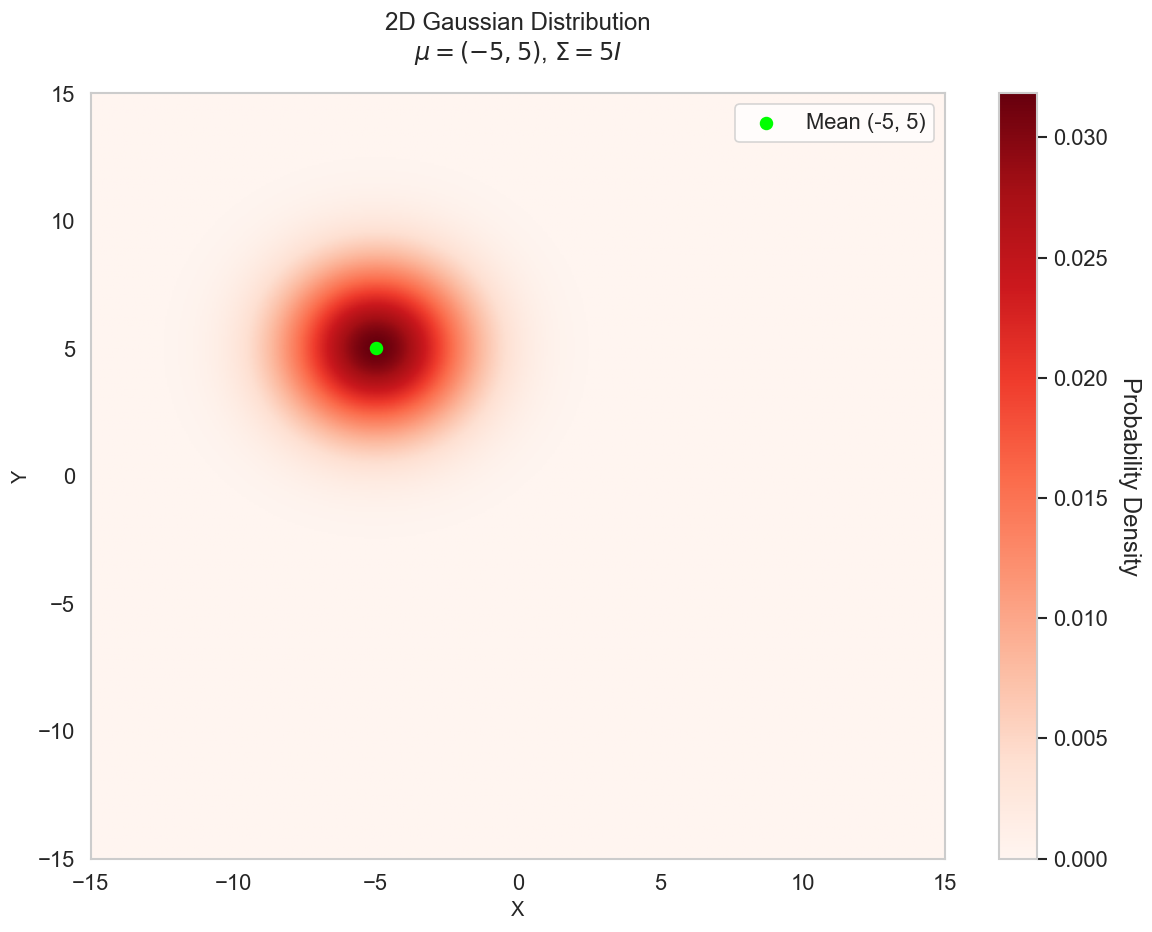

In [266]:
# 1. Define parameters
mean = np.array([-5, 5])
cov = 5 * np.eye(2)

# 2. Plotting function with corrected colors
def plot_gaussian_heatmap(mean, cov):
    # Create grid
    x = y = np.linspace(-15, 15, 500)
    X, Y = np.meshgrid(x, y)
    
    # Compute PDF
    rv = multivariate_normal(mean, cov)
    Z = rv.pdf(np.dstack((X, Y)))
    
    # Create figure
    plt.figure(figsize=(10, 8), dpi=120)
    
    
    # Plot with correct extent and normalization
    img = plt.imshow(Z, extent=[-15, 15, -15, 15], 
                    cmap='Reds', 
                    origin='lower',
                    aspect='auto',
                    )
    
    # Add mean marker
    plt.scatter(mean[0], mean[1], c='lime', s=50, 
               label=f'Mean ({mean[0]}, {mean[1]})')
    
    # Add properly scaled colorbar
    cbar = plt.colorbar(img)
    cbar.set_label('Probability Density', rotation=270, labelpad=20)
    
    plt.title('2D Gaussian Distribution\n' + 
             r'$\mu=(-5, 5)$, $\Sigma=5I$', pad=20)
    plt.xlabel('X', fontsize=12)
    plt.ylabel('Y', fontsize=12)
    plt.legend()
    plt.tight_layout()
    plt.grid(False)
    plt.show()

plot_gaussian_heatmap(mean, cov)

In [251]:
def score_function(x, mean, cov):
    """
    Computes the score (gradient of log PDF) for 2D Gaussian
    Formula: ∇ₓ log p(x) = -Σ⁻¹(x - μ)
    """
    inv_cov = np.linalg.inv(cov)
    return -inv_cov @ (x - mean)

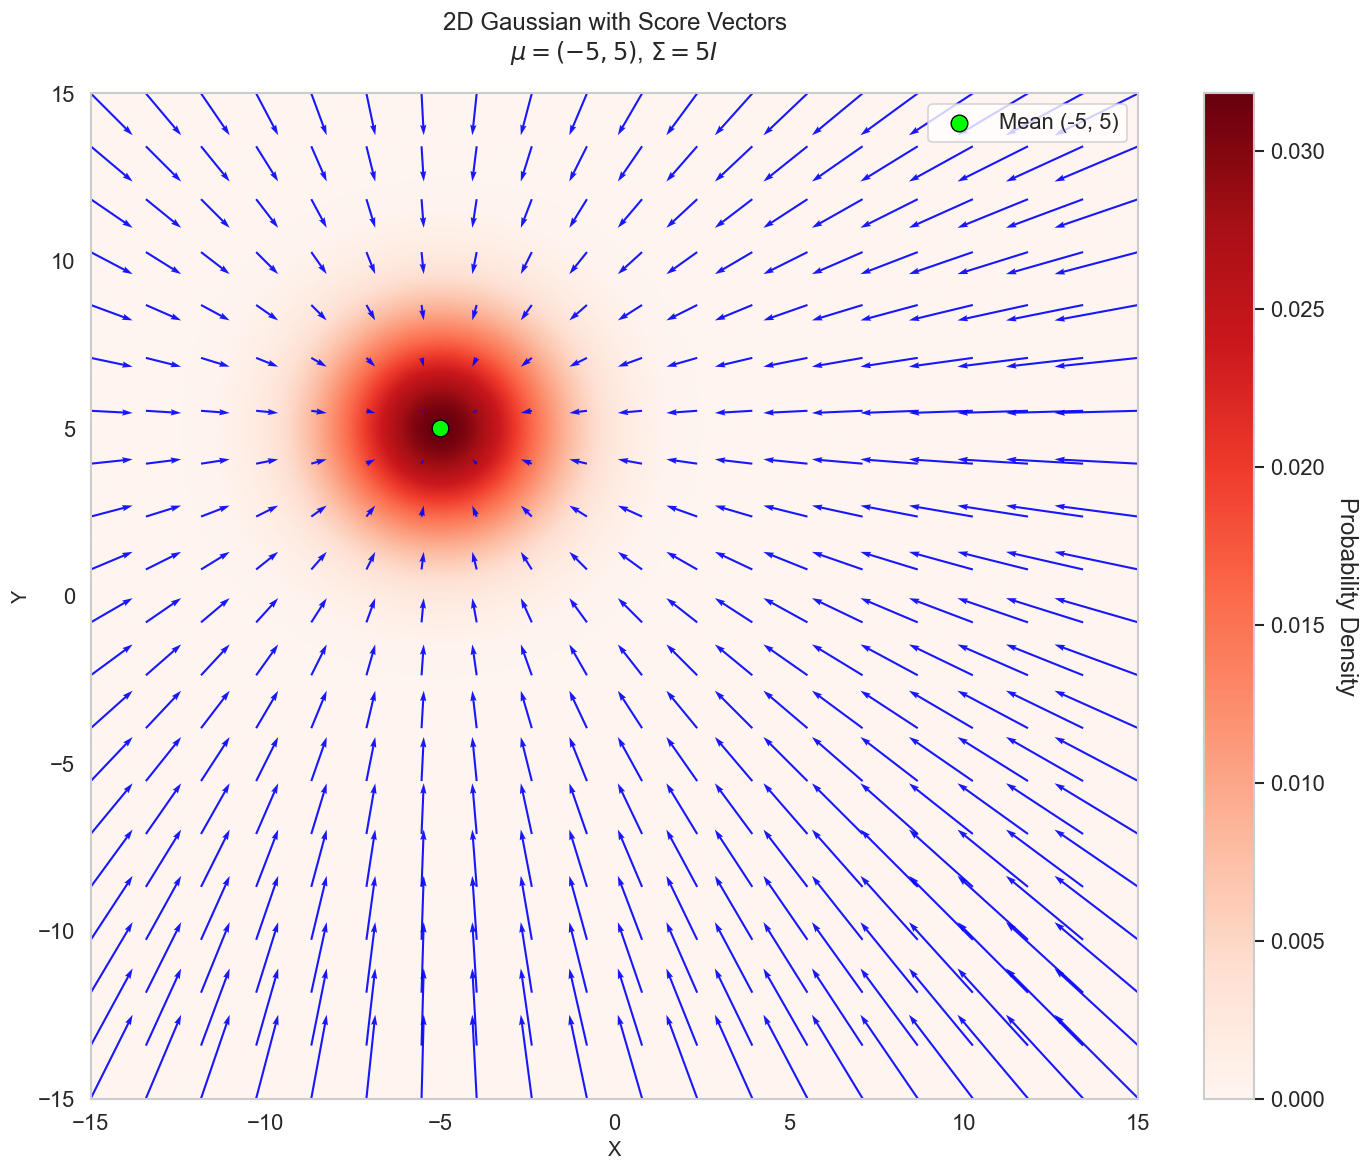

In [267]:
def plot_gaussian_with_scores(mean, cov):
    # Create dense grid for heatmap
    x_dense = y_dense = np.linspace(-15, 15, 500)
    X_dense, Y_dense = np.meshgrid(x_dense, y_dense)
    pos_dense = np.dstack((X_dense, Y_dense))
    
    # Sparse grid for vectors (20x20)
    x_sparse = y_sparse = np.linspace(-15, 15, 20)
    X_sparse, Y_sparse = np.meshgrid(x_sparse, y_sparse)
    pos_sparse = np.dstack((X_sparse, Y_sparse))
    
    # Compute PDF and scores
    rv = multivariate_normal(mean, cov)
    Z_dense = rv.pdf(pos_dense)
    
    # Compute scores at sparse grid points
    scores = np.array([score_function(pos, mean, cov) for pos in pos_sparse.reshape(-1, 2)])
    U, V = scores[:, 0].reshape(X_sparse.shape), scores[:, 1].reshape(Y_sparse.shape)
    
    # Create figure
    plt.figure(figsize=(12, 10), dpi=120)
    
    # Plot smooth heatmap using dense grid
    img = plt.imshow(Z_dense, extent=[-15, 15, -15, 15], 
                    cmap='Reds', 
                    origin='lower',
                    aspect='auto')
    
    # Plot score vectors on sparse grid
    plt.quiver(X_sparse, Y_sparse, U, V, 
              color='blue', 
              scale=50, 
              width=0.002,
              headwidth=3, 
              headlength=5,
              alpha=0.9)
    
    # Add mean marker
    plt.scatter(mean[0], mean[1], c='lime', s=100, 
               edgecolor='black',  # Add border for contrast
               linewidth=0.8,
               label=f'Mean ({mean[0]}, {mean[1]})')
    
    # Formatting
    cbar = plt.colorbar(img)
    cbar.set_label('Probability Density', rotation=270, labelpad=20)
    plt.title('2D Gaussian with Score Vectors\n' + 
             r'$\mu=(-5, 5)$, $\Sigma=5I$', pad=20)
    plt.xlabel('X', fontsize=12)
    plt.ylabel('Y', fontsize=12)
    plt.legend(loc='upper right')
    plt.grid(False)
    plt.tight_layout()
    plt.show()

plot_gaussian_with_scores(mean, cov)

In [253]:
def langevin_dynamics(initial_points, score_func, n_steps=1000, epsilon=0.1):
    """
    Runs Langevin Dynamics sampling
    
    Parameters:
    - initial_points: array of shape (n_samples, 2) with starting positions
    - score_func: function that computes ∇ₓ log p(x)
    - n_steps: number of iterations
    - epsilon: step size
    
    Returns:
    - samples: final positions after Langevin Dynamics
    - trajectories: full history of all points' paths
    """
    trajectories = []
    current_points = initial_points.copy()
    trajectories.append(current_points.copy())
    
    for _ in range(n_steps):
        # Compute score for all points
        scores = np.apply_along_axis(score_func, 1, current_points)
        
        # Generate Gaussian noise
        noise = np.random.randn(*current_points.shape) * np.sqrt(2 * epsilon)
        
        # Update positions
        current_points = current_points + epsilon * scores + noise
        trajectories.append(current_points.copy())
    
    return current_points, np.array(trajectories)

In [268]:
def plot_langevin_trajectories(mean, cov, trajectories):
    """
    Plots the Gaussian heatmap with Langevin Dynamics trajectories
    
    Parameters:
    - mean: mean of the Gaussian
    - cov: covariance matrix
    - trajectories: array of shape (n_steps+1, n_samples, 2)
    """
    # Create grid for heatmap
    x = y = np.linspace(-15, 15, 500)
    X, Y = np.meshgrid(x, y)
    pos = np.dstack((X, Y))
    
    # Compute Gaussian PDF
    rv = multivariate_normal(mean, cov)
    Z = rv.pdf(pos)
    
    # Create figure
    plt.figure(figsize=(12, 10), dpi=120)
    
    # Plot heatmap
    img = plt.imshow(Z, extent=[-15, 15, -15, 15], 
                    cmap='Reds', 
                    origin='lower',
                    aspect='auto')
    
    # Plot trajectories (first 100 for clarity)
    n_trajectories_to_plot = min(100, trajectories.shape[1])
    for i in range(n_trajectories_to_plot):
        x = trajectories[:, i, 0]
        y = trajectories[:, i, 1]
        
        # # Plot trajectory as a faint line
        # plt.plot(x, y, color='blue', alpha=0.7, linewidth=0.8)
        
        # Add arrows at each step to indicate movement direction
        plt.quiver(x[:-1], y[:-1], x[1:] - x[:-1], y[1:] - y[:-1], 
                   angles='xy', scale_units='xy', scale=1, color='blue', alpha=0.6, width=0.0015)
    
    # Plot final positions
    final_points = trajectories[-1]
    plt.scatter(final_points[:, 0], final_points[:, 1], 
               color='lime', 
               s=50,
               edgecolor='black',
               linewidth=0.8,
               label='Final samples',
               zorder=3)

    
    # Formatting
    plt.colorbar(img).set_label('Probability Density', rotation=270, labelpad=20)
    plt.title(f'Langevin Dynamics Sampling\n{n_trajectories_to_plot} Trajectories Shown', pad=20)
    plt.xlabel('X', fontsize=12)
    plt.ylabel('Y', fontsize=12)
    plt.legend()
    plt.tight_layout()
    plt.grid(True)
    plt.show()

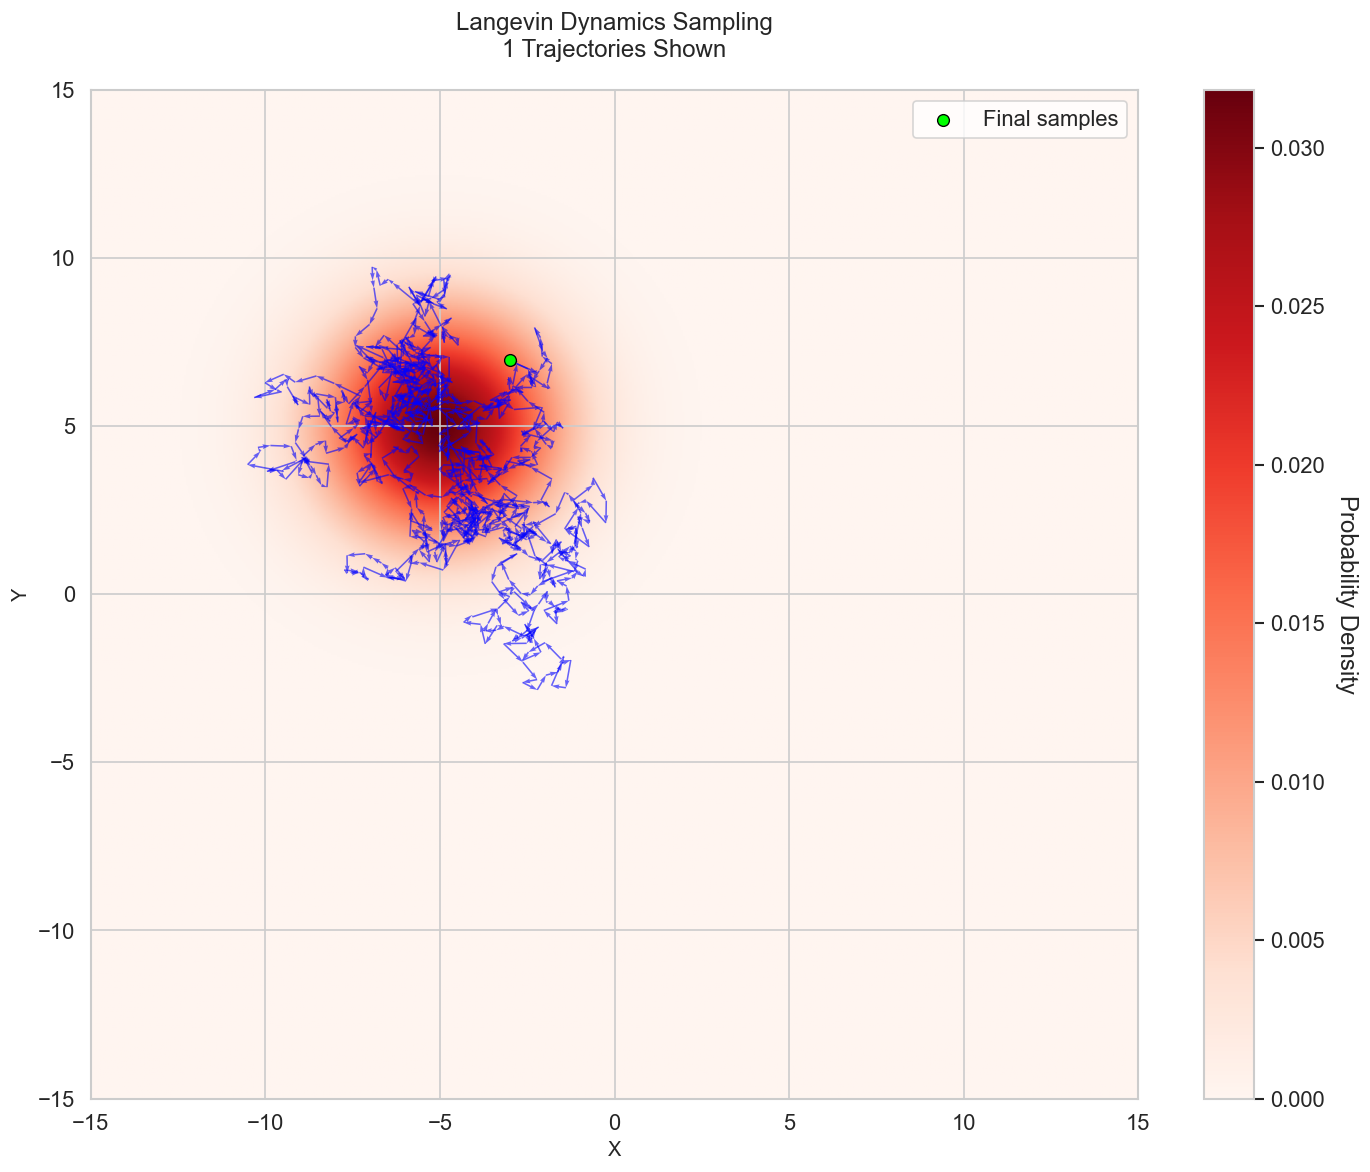

In [291]:
# Example usage:
np.random.seed(41)

# 1. Generate initial points
n_samples = 1
initial_points = np.random.randn(n_samples, 2) * 7 # Scale by 7 to get good spread
initial_points = np.clip(initial_points, -15, 15) 

# 2. Run Langevin Dynamics
samples, trajectories = langevin_dynamics(
    initial_points=initial_points,
    score_func=lambda x: score_function(x, mean, cov),
    n_steps=1000,
    epsilon=0.05
)

# 3. Plot results
plot_langevin_trajectories(mean, cov, trajectories)

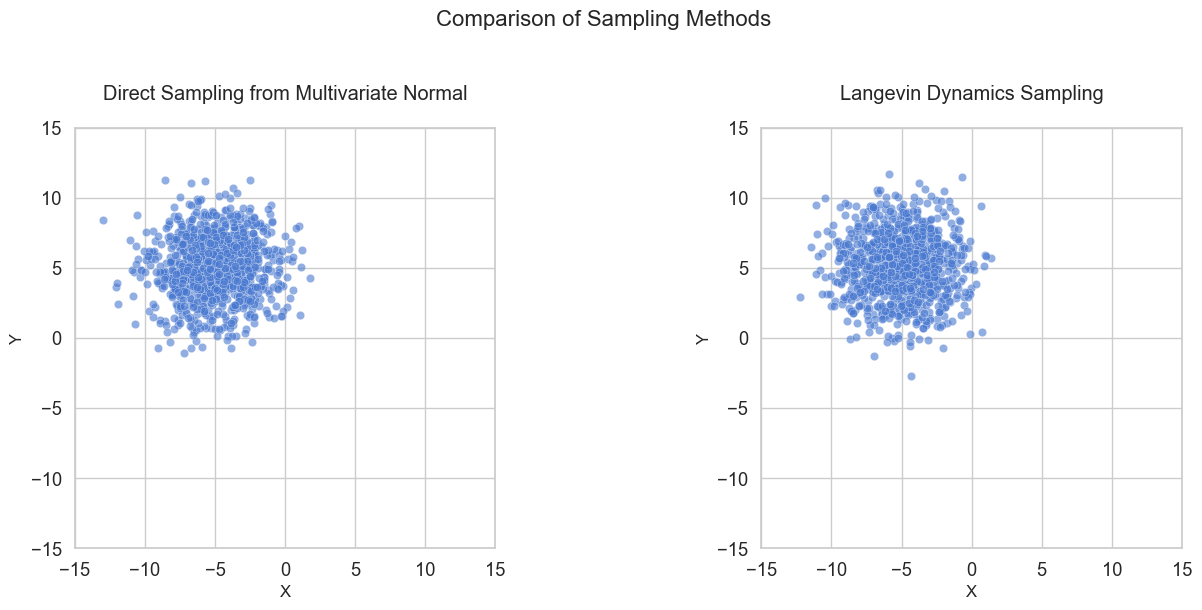

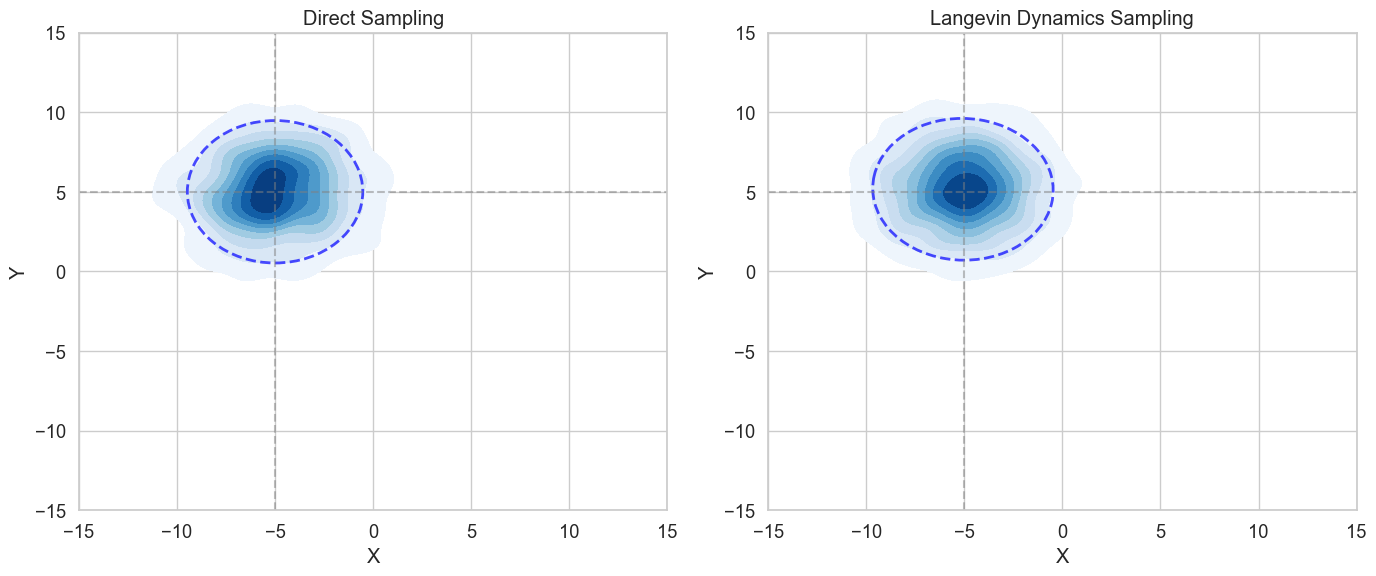

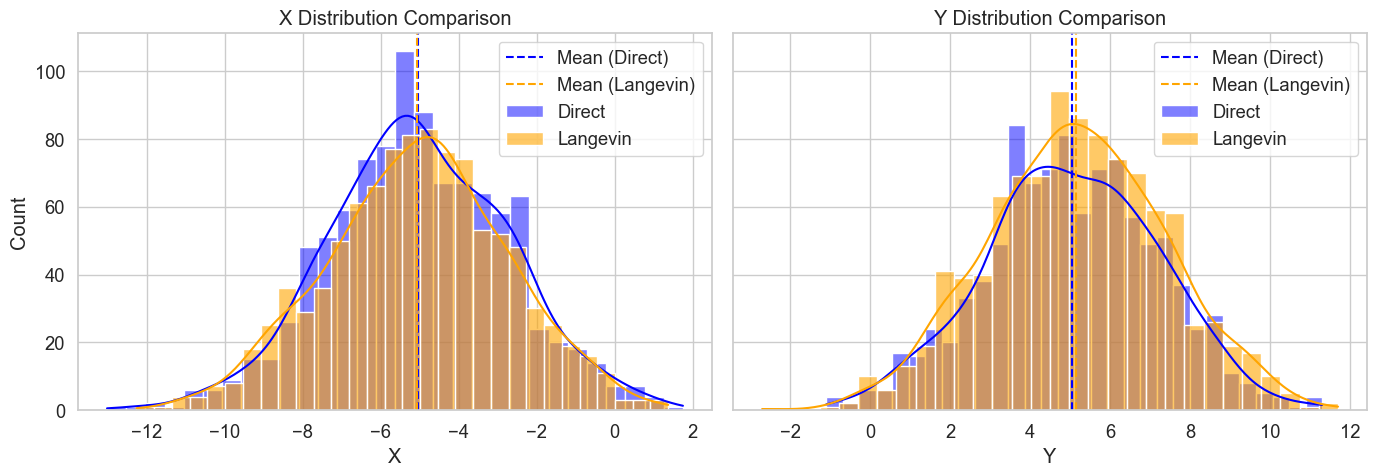

In [292]:
# 4. Compare with direct sampling
n_samples = 1000
initial_points = np.random.randn(n_samples, 2) * 7 # Scale by 7 to get good spread
initial_points = np.clip(initial_points, -15, 15) 

# 2. Run Langevin Dynamics
samples, trajectories = langevin_dynamics(
    initial_points=initial_points,
    score_func=lambda x: score_function(x, mean, cov),
    n_steps=1000,
    epsilon=0.05
)

direct_samples = np.random.multivariate_normal(mean, cov, n_samples)
# Set seaborn style for a more professional look

plt.figure(figsize=(14, 6))

# Plot Direct Sampling
plt.subplot(1, 2, 1)
sns.scatterplot(x=direct_samples[:, 0], y=direct_samples[:, 1], 
                alpha=0.6, edgecolor='w', linewidth=0.3)
plt.title('Direct Sampling from Multivariate Normal', pad=20)
plt.xlabel('X', fontsize=12)
plt.ylabel('Y', fontsize=12)
plt.xlim(-15, 15)
plt.ylim(-15, 15)
plt.gca().set_aspect('equal')

# Plot Langevin Dynamics Samples
plt.subplot(1, 2, 2)
sns.scatterplot(x=samples[:, 0], y=samples[:, 1], 
                alpha=0.6, edgecolor='w', linewidth=0.3)
plt.title('Langevin Dynamics Sampling', pad=20)
plt.xlabel('X', fontsize=12)
plt.ylabel('Y', fontsize=12)
plt.xlim(-15, 15)
plt.ylim(-15, 15)
plt.gca().set_aspect('equal')

# Adjust layout and add super title if desired
plt.suptitle('Comparison of Sampling Methods', y=1.02, fontsize=16)
plt.tight_layout()

# Optionally save the figure with high DPI
# plt.savefig('sampling_comparison.png', dpi=300, bbox_inches='tight')

plt.show()


# Function to plot covariance ellipse
def plot_cov_ellipse(ax, mean, cov, color, n_std=2):
    eigvals, eigvecs = np.linalg.eigh(cov)
    angle = np.degrees(np.arctan2(eigvecs[1, 0], eigvecs[0, 0]))
    width, height = 2 * n_std * np.sqrt(eigvals)
    ellipse = Ellipse(xy=(mean[0], mean[1]), width=width, height=height, 
                      angle=angle, facecolor='none', edgecolor=color, 
                      linewidth=2, linestyle='--', alpha=0.7)
    ax.add_patch(ellipse)

# Set Seaborn style
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.2)

# Convert samples to DataFrame
df_direct = pd.DataFrame(direct_samples, columns=['X', 'Y'])
df_direct['Method'] = 'Direct Sampling'
df_langevin = pd.DataFrame(samples, columns=['X', 'Y'])
df_langevin['Method'] = 'Langevin Dynamics'

# Create figure with two subplots (Scatter + KDE)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Direct Sampling
sns.kdeplot(data=df_direct, x='X', y='Y', fill=True, cmap="Blues", ax=axes[0])
# sns.scatterplot(data=df_direct, x='X', y='Y', color='blue', alpha=0.3, ax=axes[0], s=10)
plot_cov_ellipse(axes[0], mean, cov, 'blue')
axes[0].set_title("Direct Sampling")

# Langevin Dynamics Sampling
sns.kdeplot(data=df_langevin, x='X', y='Y', fill=True, cmap="Blues", ax=axes[1])
# sns.scatterplot(data=df_langevin, x='X', y='Y', color='blue', alpha=0.3, ax=axes[1], s=10)
plot_cov_ellipse(axes[1], np.mean(samples, axis=0), np.cov(samples.T), 'blue')
axes[1].set_title("Langevin Dynamics Sampling")

# Formatting
for ax in axes:
    ax.set_xlim(-15, 15)
    ax.set_ylim(-15, 15)
    ax.axvline(mean[0], color='gray', linestyle='--', alpha=0.5)
    ax.axhline(mean[1], color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# 🔥 **Marginal X and Y Distributions with Mean Lines**
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# X Distribution
sns.histplot(df_direct['X'], bins=30, color="blue", kde=True, ax=axes[0], label="Direct")
sns.histplot(df_langevin['X'], bins=30, color="orange", kde=True, ax=axes[0], label="Langevin", alpha=0.6)
axes[0].axvline(df_direct['X'].mean(), color='blue', linestyle='--', label='Mean (Direct)')
axes[0].axvline(df_langevin['X'].mean(), color='orange', linestyle='--', label='Mean (Langevin)')
axes[0].set_title("X Distribution Comparison")
axes[0].legend()

# Y Distribution
sns.histplot(df_direct['Y'], bins=30, color="blue", kde=True, ax=axes[1], label="Direct")
sns.histplot(df_langevin['Y'], bins=30, color="orange", kde=True, ax=axes[1], label="Langevin", alpha=0.6)
axes[1].axvline(df_direct['Y'].mean(), color='blue', linestyle='--', label='Mean (Direct)')
axes[1].axvline(df_langevin['Y'].mean(), color='orange', linestyle='--', label='Mean (Langevin)')
axes[1].set_title("Y Distribution Comparison")
axes[1].legend()

plt.tight_layout()
plt.show()


<Figure size 1400x600 with 0 Axes>

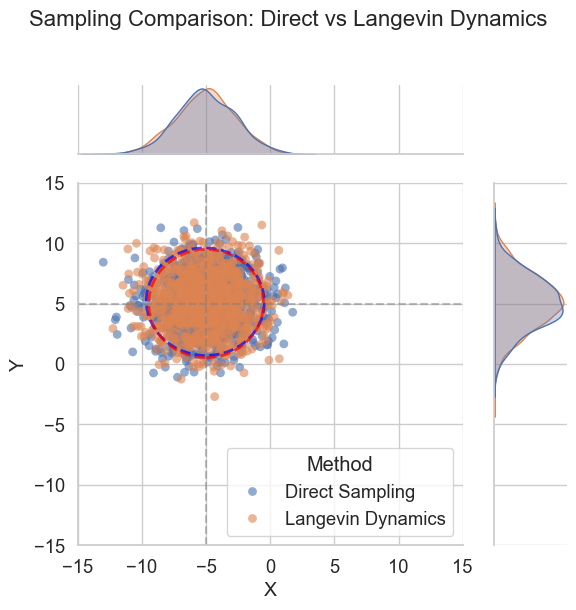

In [293]:
plt.figure(figsize=(14, 6))

# Create DataFrame for plotting
df_direct = pd.DataFrame(direct_samples, columns=['x', 'y'])
df_direct['Method'] = 'Direct Sampling'
df_langevin = pd.DataFrame(samples, columns=['x', 'y'])
df_langevin['Method'] = 'Langevin Dynamics'
df_combined = pd.concat([df_direct, df_langevin])

# Create JointGrid
g = sns.JointGrid(data=df_combined, x='x', y='y', hue='Method', 
                 height=6, ratio=4, palette=["#4C72B0", "#DD8452"])

# Plot joint scatterplot
g.plot_joint(
    sns.scatterplot,
    alpha=0.6,
    edgecolor='none',
    s=40
)

# Plot marginal KDEs
g.plot_marginals(
    sns.kdeplot,
    fill=True,
    alpha=0.3,
    linewidth=1
)

# Customize plot
g.set_axis_labels('X', 'Y', fontsize=14)
g.fig.suptitle('Sampling Comparison: Direct vs Langevin Dynamics', y=1.02, fontsize=16)
g.ax_joint.set_xlim(-15, 15)
g.ax_joint.set_ylim(-15, 15)

# Add mean lines
g.ax_joint.axvline(mean[0], color='gray', linestyle='--', alpha=0.5)
g.ax_joint.axhline(mean[1], color='gray', linestyle='--', alpha=0.5)

# Fixed covariance ellipse function
def plot_cov_ellipse(ax, mean, cov, color, n_std=2):
    eigvals, eigvecs = np.linalg.eigh(cov)
    angle = np.degrees(np.arctan2(eigvecs[1,0], eigvecs[0,0]))
    width, height = 2 * n_std * np.sqrt(eigvals)
    # Pack mean coordinates into a tuple for xy parameter
    ellipse = Ellipse(xy=(mean[0], mean[1]), width=width, height=height, angle=angle,
                     facecolor='none', edgecolor=color, 
                     linewidth=2, linestyle='--', alpha=0.7)
    ax.add_patch(ellipse)

# Plot ellipses
plot_cov_ellipse(g.ax_joint, np.mean(samples, axis=0), np.cov(samples.T), 'blue')
plot_cov_ellipse(g.ax_joint, mean, cov, 'red')

plt.tight_layout()
plt.show()

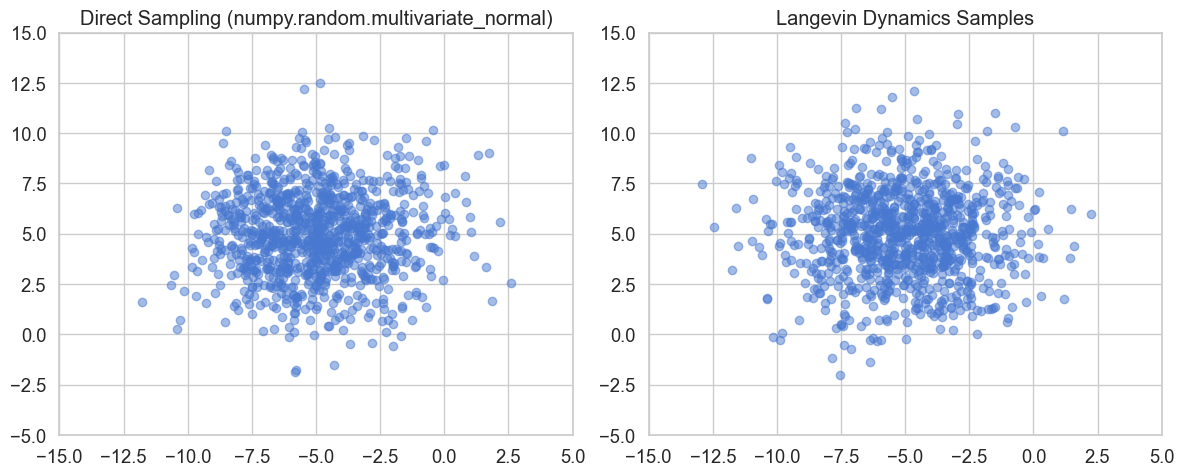

KL Divergence between direct and Langevin samples: 0.0625


In [ ]:
# 7. Compare with direct sampling
langevin_samples = trajectories[-1]  # Final positions
direct_samples = np.random.multivariate_normal(mean, cov, 1000)

# Plot comparison
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(direct_samples[:, 0], direct_samples[:, 1], alpha=0.5)
plt.title('Direct Sampling (numpy.random.multivariate_normal)')
plt.xlim(-15, 5)
plt.ylim(-5, 15)

plt.subplot(1, 2, 2)
plt.scatter(langevin_samples[:, 0], langevin_samples[:, 1], alpha=0.5)
plt.title('Langevin Dynamics Samples')
plt.xlim(-15, 5)
plt.ylim(-5, 15)

plt.tight_layout()
plt.show()

# 8. Quantitative comparison (Kullback-Leibler divergence)
from scipy.stats import gaussian_kde

# Estimate KL divergence between samples
def estimate_kl(samples_p, samples_q):
    # Estimate densities
    kde_p = gaussian_kde(samples_p.T)
    kde_q = gaussian_kde(samples_q.T)
    
    # Evaluate on p samples
    log_p = kde_p.logpdf(samples_p.T)
    log_q = kde_q.logpdf(samples_p.T)
    
    return np.mean(log_p - log_q)

kl_divergence = estimate_kl(direct_samples, langevin_samples)
print(f"KL Divergence between direct and Langevin samples: {kl_divergence:.4f}")